# Parameter Search and Download Tutorial

### Overview
The combination of the [RESTful parameterized search](https://docs.hubmapconsortium.org/param-search/index.html) and the [HuBMAP Command Line Transfer Tool](https://docs.hubmapconsortium.org/clt/index.html) provides for an easy way to programatically query HuBMAP data and download the results of the query.

### Description
Below is an example of how to use the [RESTful parameterized search endpoint](https://docs.hubmapconsortium.org/param-search/index.html) to query for datasets with specific attributes and produce a manifest of datasets to download and how to use the manifest to download all of the data for the referenced Datasets. The parameterized search feature shown in this example is a simple query mechanism that allows quick querying of data via a single RESTful URL call where queried attributes are constrained to exact string matches of a limited set of attributes, where the query is an "AND" filtered query with all attribute matches as terms in the "AND" clause, for example the query `/param-search/datasets?status=Published&dataset_type=CODEX` will return all datasets that are "Published AND a result of a CODEX assay".  If more complex queries are desired use the standard `/search` endpoint which is documented in the [HuBMAP Search API Endpoints](https://smart-api.info/ui/7aaf02b838022d564da776b03f357158).

This example uses the Python Requests library to send the parameter search query and retrieve the results. If Requests hasn't been installed run `pip install requests` in the environment that this notbook is running in.  A version of this example using the command line `curl` command can be found in the [Example Query and Download page](https://docs.hubmapconsortium.org/param-search/data-query-download-example.html)


### Example Query and Download

The following query will return all CODEX (`dataset_type=CODEX`) Datasets run on a Keyence BZ-X800 machine (`metadata.acquisition_instrument_model=BZ-X800`) where tissue from a spleen was used (`origin_samples.organ=SP`).  See the [RESTful parameterized search page](https://docs.hubmapconsortium.org/param-search/index.html) for further information on querying dataset, organ (`origin_samples.organ` represents the organ in the query and `SP` is the organ code (organ code list available [here](https://docs.hubmapconsortium.org/schema-sample.html#organ-attribute-values)) and dataset metadata fields.

```
GET https://search.api.hubmapconsortium.org/v3/param-search/datasets?dataset_type=CODEX&metadata.acquisition_instrument_model=BZ-X800&origin_samples.organ=SP
```

#### Producing a CLT manifest file

As is, if this query is submitted via HTTP GET it will produce a json Response with an array of dataset objects which match the query.  Adding the `produce-clt-manifest=true` option to this query will instead prduce a list of Dataset IDs pointing to the Datasets that match this query in a format that will be directly usable by the [HuBMAP Command Line Transfer Tool](.https://docs.hubmapconsortium.org/clt/index.html).

```
GET https://search.api.hubmapconsortium.org/v3/param-search/datasets?dataset_type=CODEX&metadata.acquisition_instrument_model=BZ-X800&origin_samples.organ=SP&produce-clt-manifest=true
```

#### Make the query request and get the manifest information
The code below, does the request as specified above with a lot of error checking

In [ ]:
#imports
import os
import requests

#run the query, get the results, report any errors
query_url =  'https://search.api.hubmapconsortium.org/v3/param-search/datasets?dataset_type=CODEX&metadata.acquisition_instrument_model=BZ-X800&origin_samples.organ=SP&produce-clt-manifest=true'
try:
    manifest_text = None
    
    #make request and grap the HTTP response code
    response = requests.get(query_url)
    response_code = response.status_code
    
    #per API docs, /param-search/ can send several response codes
    #handle all of those cases
    if response_code == 200:
        manifest_text = response.text
    #if the response size is > 10MB, a redirect to an S3 bucket is sent
    #retrieve the manifext information from the S3 bucket
    elif response_code == 303:
        next_url = response.text
        next_response = requests.get(next_url)
        if next_response.status_code == 200:
            manifest_text = next_response.text
        else:
            print(f"Unable to retrieve from redirect {next_response.status_code}: {next_response.text}")
            print(f"Redirect URL: {next_url}")
    #we'll get a 404 if the URL is wrong OR IF NO DATA HAS BEEN found when the produce-clt-manifest option has been used
    elif response_code == 404:
        print("Endpoint not found or no data matching this query.")
    #if the query times out
    elif response_code == 504:
        print("The query timed out after 30 seconds")
    else:
        print(f"Unable to retrieve query {response_code}: {response.text}")
except Exception as err:
    print(f"An unexpected error occurred: {err}")

if not manifest_text is None:
    print("Success")
else:
    print("Fail")

### Write the manifest file

In [ ]:
#if manifest information was retrieved write the manifext file otherwise print an error message
if not manifest_text is None:
    fname = "dataset_download_manifest.out"
    with open(fname, 'w') as file:                                                                                           
        file.write(manifest_text)
    print(f"manifest file written at: {os.path.abspath(fname)}")
else:
    print("ERROR: No manifext information found.  File not written")


### Use the HuBMAP CLT to download the file

To use the HuBMAP CLT tool to download the data for the datasets referenced in the generated mainifest file:

  - Install the Globus Connect Personal client and the HuBMAP CLT per the [HuBMAP CLT Setup Instructions](https://docs.hubmapconsortium.org/clt/install-hubmap-clt.html)
    - Setup Note: A common issue arrises between the configuration of the GCP client and HuBMAP CLT.  By default HuBMAP CLT stores files in the user's home directory under a directory called `hubmap-downloads`, so make sure to configure the GCP client by goint to "Preferences"-->"Access" and adding the `hubmap-downloads` directory in the user's home like (Example shown is Mac OS X):<br/><br/>
   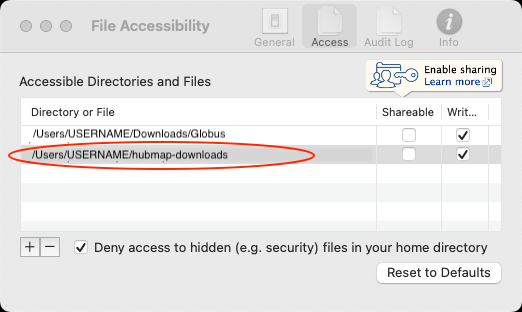
   <br/><br/>
  - On the command line, change to the directory where the into the directory where the mainifest file was generated (printed in the last step), then log into HuBMAP Globus server using:
  
  ```
  cd /my/directory/where/manifest/file/sits
  hubmap-clt login
  ```
  Globus login screen will open in your default web browser.  Follow the instructions to log in.  For publicly available HuBMAP data any login will work (your institution, Google, GitHub, etc..).
  - Download the data using the manifest file genrated above:
  ```
  hubmap-clt transfer dataset-manifest-for-download.out
  ```

Futher instructions on the usage of the HuBMAP CLT are available on the main [HuBMAP Command Line Transfer Tool page](https://docs.hubmapconsortium.org/clt/index.html)